# **Libraries**

# **Exploratory Analysis**

*   Data Cleaning

# **Data Pre-Processing**

# **Data Visualization**

# **Classification**


*   Regression analysis
*   Random Forest








In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 6.3 MB 57.5 MB/s 


 **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas.tools import geocode
import plotly.express as px


# **Analysis...**

In [ ]:
#loading the dataset
data = pd.read_csv('zika.csv')

In [ ]:
data.head()
data

,Country,Date,"Cumulative no. of confirmed, probable and suspected cases","Cumulative no. of confirmed, probable and suspected deaths"
0,Guinea,29-08-2014,648.0,430
1,Nigeria,29-08-2014,19.0,7
2,Sierra Leone,29-08-2014,1026.0,422
3,Liberia,29-08-2014,1378.0,694
4,Sierra Leone,05-09-2014,1261.0,491
...,...,...,...,...
2480,Liberia,23-03-2016,10666.0,4806
2481,Italy,23-03-2016,1.0,0
2482,Liberia,23-03-2016,5.0,4
2483,Nigeria,23-03-2016,20.0,8


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2485 entries, 0 to 2484
Data columns (total 4 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Country                                                     2485 non-null   object 
 1   Date                                                        2485 non-null   object 
 2   Cumulative no. of confirmed, probable and suspected cases   2477 non-null   float64
 3   Cumulative no. of confirmed, probable and suspected deaths  2485 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 77.8+ KB


In [ ]:
idsUnique=len(set(data.Date))
idsTotal=len(data)
print("duplicate ids "+str(idsTotal-idsUnique))

duplicate ids 2226


In [ ]:
numeric_features=data.select_dtypes(include=[np.number])
numeric_features.dtypes

Cumulative no. of confirmed, probable and suspected cases     float64
Cumulative no. of confirmed, probable and suspected deaths      int64
dtype: object

In [ ]:
corr=numeric_features.corr()
corr

,"Cumulative no. of confirmed, probable and suspected cases","Cumulative no. of confirmed, probable and suspected deaths"
"Cumulative no. of confirmed, probable and suspected cases",1.0000,0.9558
"Cumulative no. of confirmed, probable and suspected deaths",0.9558,1.0000


# **Data Cleaning**

In [ ]:
data.columns = ['Country', 'Date', 'Cumulative no. cases', 'Cumulative no. deaths']

# fix data
for col in ['Cumulative no. cases', 'Cumulative no. deaths']:
    # fill na with 0
    data[col] = data[col].fillna(0)
    # convert data type to 'int'
    data[col] = data[col].astype('int')
    
# group by date and country
data = data.groupby(['Date', 'Country'])['Cumulative no. cases', 'Cumulative no. deaths'].sum()

# reset index
data = data.reset_index()

# CFR
data['CFR'] = round((data['Cumulative no. deaths'] / data['Cumulative no. cases']) * 100, 2)

# first few rows
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Date,Country,Cumulative no. cases,Cumulative no. deaths,CFR
0,01-05-2015,Guinea,3578,2383,66.60
1,01-05-2015,Liberia,10322,4608,44.64
2,01-05-2015,Mali,8,6,75.00
3,01-05-2015,Nigeria,20,8,40.00
4,01-05-2015,Senegal,1,0,0.00


In [ ]:
data['Country'].value_counts().sort_index()

Guinea                      259
Italy                       141
Liberia                     259
Mali                        243
Nigeria                     255
Senegal                     254
Sierra Leone                259
Spain                       243
United Kingdom              221
United States of America    245
Name: Country, dtype: int64

In [ ]:
data['Date'].value_counts().sort_index(ascending=False)[:15]

31-12-2014     8
31-10-2014     8
31-08-2015    10
31-07-2015    10
30-12-2014     8
30-10-2015    10
30-09-2015    10
30-07-2015    10
30-06-2015    10
30-04-2015     9
30-01-2015     9
29-12-2015    10
29-12-2014     8
29-10-2015    10
29-10-2014     8
Name: Date, dtype: int64

In [ ]:
temp = data.groupby(['Country', 'Date', ])['Cumulative no. cases', 'Cumulative no. deaths']
temp = temp.sum().diff().reset_index()

mask = temp['Country'] != temp['Country'].shift(1)

temp.loc[mask, 'Cumulative no. cases'] = np.nan
temp.loc[mask, 'Cumulative no. deaths'] = np.nan

# renaming columns
temp.columns = ['Country', 'Date', 'New cases', 'New deaths']

# merging new values
data = pd.merge(data, temp, on=['Country', 'Date'])

# filling na with 0
data = data.fillna(0)

# fixing data types
cols = ['New cases', 'New deaths']
data[cols] = data[cols].astype('int')

data['New cases'] = data['New cases'].apply(lambda x: 0 if x<0 else x)

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Date,Country,Cumulative no. cases,Cumulative no. deaths,CFR,New cases,New deaths
0,01-05-2015,Guinea,3578,2383,66.60,0,0
1,01-05-2015,Liberia,10322,4608,44.64,0,0
2,01-05-2015,Mali,8,6,75.00,0,0
3,01-05-2015,Nigeria,20,8,40.00,0,0
4,01-05-2015,Senegal,1,0,0.00,0,0


In [ ]:
latest = data[data['Date']==max(data['Date'])]
latest = latest.sort_values('Cumulative no. cases', ascending=False)
latest = latest.reset_index()
latest

,index,Date,Country,Cumulative no. cases,Cumulative no. deaths,CFR,New cases,New deaths
0,2376,31-12-2014,Sierra Leone,9446,2758,29.20,4108,1248
1,2372,31-12-2014,Liberia,8018,3423,42.69,1483,1010
2,2371,31-12-2014,Guinea,2707,1709,63.13,1040,691
3,2374,31-12-2014,Nigeria,20,8,40.00,0,0
4,2373,31-12-2014,Mali,8,6,75.00,7,5
5,2378,31-12-2014,United States of America,4,1,25.00,0,0
6,2375,31-12-2014,Senegal,1,0,0.00,0,0
7,2377,31-12-2014,Spain,1,0,0.00,0,0


# **Data Pre-Processing & Visualization**

In [ ]:
from sklearn import preprocessing

df=pd.read_csv('/content/zikadata.csv')
df.head()

,Country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
0,Guinea,2014-08-29,25.0,141.0,482.0,648.0,2.0,141.0,287.0,430.0
1,Nigeria,2014-08-29,3.0,1.0,15.0,19.0,0.0,1.0,6.0,7.0
2,Sierra Leone,2014-08-29,54.0,37.0,935.0,1026.0,8.0,34.0,380.0,422.0
3,Liberia,2014-08-29,382.0,674.0,322.0,1378.0,168.0,301.0,225.0,694.0
4,Sierra Leone,2014-09-05,78.0,37.0,1146.0,1261.0,11.0,37.0,443.0,491.0


In [ ]:
from datetime import datetime
import matplotlib.ticker as ticker

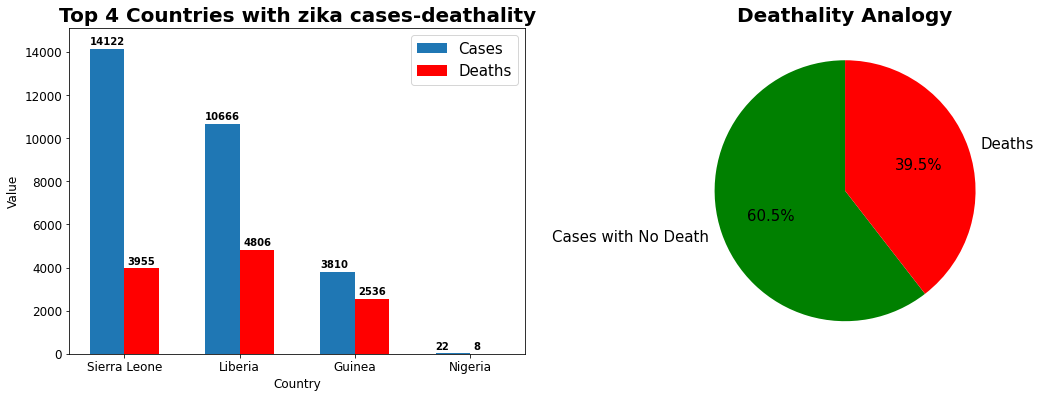

In [ ]:
#top 4 countries with most zika cases
dftemp = df.sort_values(by="No. of confirmed, probable and suspected cases", ascending=False)
countries = dftemp["Country"].unique()[0:4]
cases = []
for c in countries:
    cases.append(np.sort(df.loc[df['Country'] == c]["No. of confirmed, probable and suspected cases"].unique())[-1])
f , ax  = plt.subplots(1,2,figsize=(18,6))
ax[0].bar(np.arange(0,4),cases,width=0.3, label = 'Cases')
ax[0].set_title('Top 4 Countries with zika cases-deathality',fontsize=20, fontweight='bold')
ax[0].set_xlabel('Country',fontsize=12)
ax[0].set_ylabel('Value',fontsize=12)
counter = 0
for i in cases:
    ax[0].text(counter-0.15, i+200, int(i), color='black', fontsize=10, fontweight='bold')
    counter +=1 
ax[0].set_ylim([0,cases[0]+1000])
#top 4 countries in deathality from zika
dftemp = df.sort_values(by = "No. of confirmed, probable and suspected deaths", ascending = False)
countriesD = dftemp['Country'].unique()[0:4]
deaths = []
for c in countries:
    deaths.append(np.sort(df.loc[dftemp['Country'] == c]["No. of confirmed, probable and suspected deaths"].unique())[-1])
deaths
ax[0].bar(np.arange(0,4)+0.3, deaths, width = 0.3, color = 'red', label = 'Deaths')
ax[0].set_xticks(np.arange(0,4)+0.3/2)
ax[0].set_xticklabels(countries)
ax[0].tick_params(axis='both',labelsize=12)
counter = 0
for i in deaths:
    ax[0].text(counter-0.12+0.3, i+200, int(i), color='black', fontsize=10, fontweight='bold')
    counter +=1 
ax[0].legend(fontsize=15)
totalCases = 0
totalDeaths = 0
for i in np.arange(0,4):
    totalCases += cases[i]
    totalDeaths += deaths[i]
ax[1].pie([totalCases-totalDeaths,totalDeaths],radius = 1,labels=['Cases with No Death','Deaths'],startangle=90,colors = ['green','red'], textprops={'fontsize': 15},autopct='%1.1f%%')
ax[1].set_title('Deathality Analogy',fontsize=20,fontweight='bold')
plt.show()

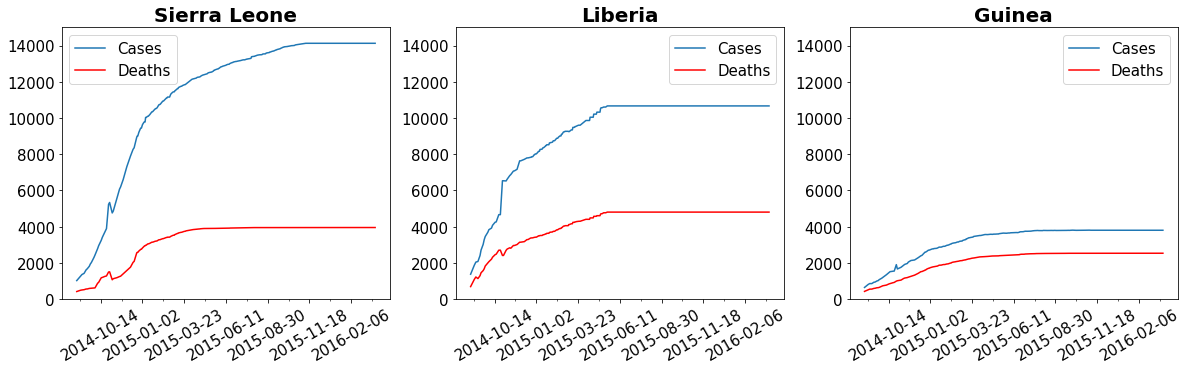

In [ ]:
#ploting the virus spreading in time
#we will plot the outbreak timeline in the 3 countries with the most of the cases
#plotting Sierra Leone
f, ax = plt.subplots(1,3,figsize=(20,5))
temp = df.loc[df['Country'] == 'Sierra Leone']['Date'].tolist()
casesSierra = df.loc[df['Country'] == 'Sierra Leone'].sort_values(by='Date')['No. of confirmed, probable and suspected cases'].tolist()
DeathsSierra = df.loc[df['Country'] == 'Sierra Leone'].sort_values(by='Date')['No. of confirmed, probable and suspected deaths'].tolist()
timeSierra = []

for i in temp:
    timeSierra.append(datetime.strptime(i,'%Y-%m-%d'))
ax[0].plot(timeSierra, casesSierra,label='Cases')
ax[0].plot(timeSierra, DeathsSierra,color='red',label='Deaths')
ax[0].set_title('Sierra Leone',fontsize=20,fontweight='bold')
ax[0].tick_params(axis='both', labelsize=15)
ax[0].tick_params(axis='x',rotation=30)
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(8))
ax[0].xaxis.set_minor_locator(ticker.MaxNLocator(16))
ax[0].legend(fontsize='15')
ax[0].set_ylim([0,15000])

#plotting Liberia
temp = df.loc[df['Country'] == 'Liberia']['Date'].tolist()
casesLiberia = df.loc[df['Country'] == 'Liberia'].sort_values(by='Date')['No. of confirmed, probable and suspected cases'].tolist()
DeathsLiberia = df.loc[df['Country'] == 'Liberia'].sort_values(by='Date')['No. of confirmed, probable and suspected deaths'].tolist()
timeLiberia = []
for i in temp:
    timeLiberia.append(datetime.strptime(i,'%Y-%m-%d'))
    
#filtering the data
min = casesLiberia[0]
for i in range(1,len(casesLiberia)):
    if (casesLiberia[i] < min):
        casesLiberia[i] = -1
        DeathsLiberia[i] = -1
        timeLiberia[i] = ''
    else:
        min = casesLiberia[1]
casesLiberia = list(filter(lambda a: a!=-1, casesLiberia))
DeathsLiberia = list(filter(lambda a: a!=-1, DeathsLiberia))
timeLiberia = list(filter(lambda a: a!='', timeLiberia))

ax[1].plot(timeLiberia, casesLiberia,label='Cases')
ax[1].plot(timeLiberia, DeathsLiberia,color='red',label='Deaths')
ax[1].set_title('Liberia',fontsize=20,fontweight='bold')
ax[1].tick_params(axis='both', labelsize=15)
ax[1].tick_params(axis='x',rotation=30)
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(8))
ax[1].xaxis.set_minor_locator(ticker.MaxNLocator(16))
ax[1].legend(fontsize='15')
ax[1].set_ylim([0,15000])

#plotting Guinea

temp = df.loc[df['Country'] == 'Guinea']['Date'].tolist()
casesGuinea = df.loc[df['Country'] == 'Guinea'].sort_values(by='Date')['No. of confirmed, probable and suspected cases'].tolist()
DeathsGuinea = df.loc[df['Country'] == 'Guinea'].sort_values(by='Date')['No. of confirmed, probable and suspected deaths'].tolist()
timeGuinea = []
for i in temp:
    timeGuinea.append(datetime.strptime(i,'%Y-%m-%d'))

ax[2].plot(timeGuinea, casesGuinea,label='Cases')
ax[2].plot(timeGuinea, DeathsGuinea,color='red',label='Deaths')
ax[2].set_title('Guinea',fontsize=20,fontweight='bold')
ax[2].tick_params(axis='both', labelsize=15)
ax[2].tick_params(axis='x',rotation=30)
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(8))
ax[2].xaxis.set_minor_locator(ticker.MaxNLocator(16))
ax[2].legend(fontsize='15')
ax[2].set_ylim([0,15000])
f.show()

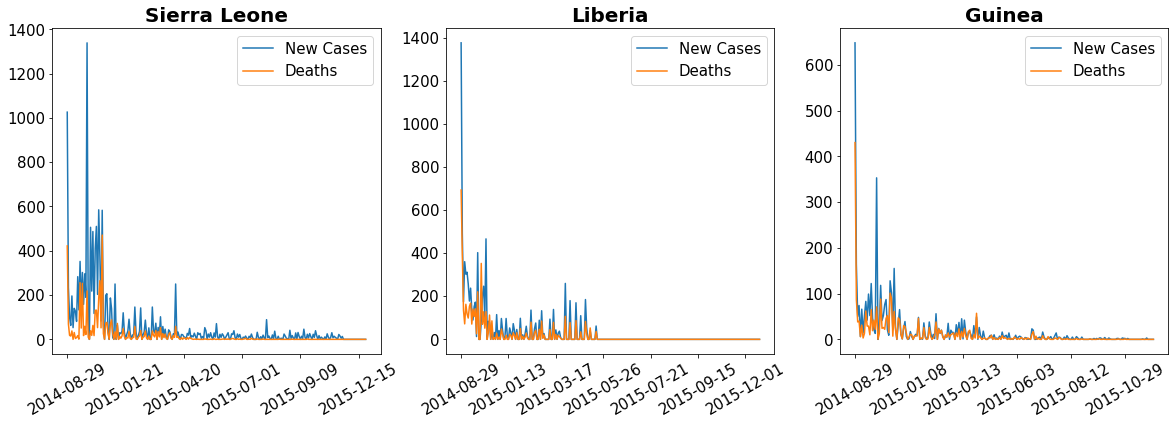

In [ ]:
#finding the cases per day...
countries = ['Sierra Leone', 'Liberia', 'Guinea']
f, ax = plt.subplots(1,3,figsize=(20,6))
valC = {}
valD = {}
dates = {}
for i in countries:
    valC[i] = df.loc[df['Country'] == i].sort_values(by='Date')['No. of confirmed, probable and suspected cases'].tolist()
    dates[i] = df.loc[df['Country'] == i].sort_values(by='Date')['Date'].tolist()
    valD[i] = df.loc[df['Country'] == i].sort_values(by='Date')['No. of confirmed, probable and suspected deaths'].tolist()
    for j in range(1,len(valC[i])):
        if (valC[i][j] < valC[i][j-1]) | (valD[i][j] < valD[i][j-1]):
            valC[i][j] = -1
            valD[i][j] = -1
            dates[i][j] = ''
    valC[i] = list(filter(lambda a: a!=-1, valC[i]))
    valD[i] = list(filter(lambda a: a!=-1, valD[i]))
    dates[i] = list(filter(lambda a: a!='', dates[i]))
    tempC = [valC[i][0]]
    tempD = [valD[i][0]]
    for j in np.arange(1,len(valD[i])):
        tC = valC[i][j] - valC[i][j-1]
        tD = valD[i][j] - valD[i][j-1]
        if(tC < 0) | (tD < 0) | (tC > 5000) | (tD > 5000):
            tC = 0
            tD = 0 
        tempC.append(tC)
        tempD.append(tD)
    valC[i] = tempC
    valD[i] = tempD
    
#plot creation
for i in np.arange(3):
    ax[i].set_title(countries[i],fontsize=20,fontweight='bold')
    ax[i].plot(dates[countries[i]],valC[countries[i]],label = 'New Cases')
    ax[i].plot(dates[countries[i]],valD[countries[i]],label = 'Deaths')
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(7))
    ax[i].tick_params(axis='x',rotation=30, labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    ax[i].legend(fontsize=15)
f.show()

**Standardization**

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 

numeric_columns = [c for c in df.columns if df[c].dtype != np.dtype('O')]
temp_data = df[numeric_columns]
standard_scaler = StandardScaler()
standardized_data = standard_scaler.fit_transform(temp_data)
pd.DataFrame(standardized_data , columns = temp_data.columns)

,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
0,-0.474121,-0.218633,-0.370915,-0.430543,-0.422474,0.225973,-0.393297,-0.361380
1,-0.486154,-0.468023,-0.552367,-0.572650,-0.449820,-0.641613,-0.616715,-0.616856
2,-0.458259,-0.403894,-0.194902,-0.345143,-0.340438,-0.437111,-0.319354,-0.366211
3,-0.278859,0.730832,-0.433082,-0.265617,1.847196,1.217499,-0.442592,-0.201934
4,-0.445133,-0.403894,-0.112918,-0.292050,-0.299420,-0.418520,-0.269264,-0.324538
...,...,...,...,...,...,...,...,...
2480,2.594829,2.877372,0.666121,1.832786,NaN,NaN,NaN,2.281561
2481,-0.487795,-0.469805,-0.557806,-0.576717,NaN,NaN,NaN,-0.621084
2482,-0.487795,-0.464461,-0.557418,-0.575813,NaN,-0.629219,-0.620691,-0.618668
2483,-0.487795,-0.468023,-0.550812,-0.572424,-0.449820,-0.641613,-0.615920,-0.616252


**Normalization**

In [ ]:
normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(temp_data)
pd.DataFrame(normalized_data , columns = temp_data.columns)

,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
0,0.004436,0.066952,0.055268,0.045886,0.003026,0.175592,0.074391,0.089471
1,0.000532,0.000475,0.001609,0.001345,0.000000,0.001245,0.001555,0.001457
2,0.009581,0.017569,0.107319,0.072653,0.012103,0.042341,0.098497,0.087807
3,0.067779,0.320038,0.036884,0.097578,0.254160,0.374844,0.058320,0.144403
4,0.013840,0.017569,0.131564,0.089293,0.016641,0.046077,0.114826,0.102164
...,...,...,...,...,...,...,...,...
2480,1.000000,0.892213,0.361944,0.755275,NaN,NaN,NaN,1.000000
2481,0.000000,0.000000,0.000000,0.000071,NaN,NaN,NaN,0.000000
2482,0.000000,0.001425,0.000115,0.000354,NaN,0.003736,0.000259,0.000832
2483,0.000000,0.000475,0.002068,0.001416,0.000000,0.001245,0.001814,0.001665


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
temp_data.head()


,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
0,25.0,141.0,482.0,648.0,2.0,141.0,287.0,430.0
1,3.0,1.0,15.0,19.0,0.0,1.0,6.0,7.0
2,54.0,37.0,935.0,1026.0,8.0,34.0,380.0,422.0
3,382.0,674.0,322.0,1378.0,168.0,301.0,225.0,694.0
4,78.0,37.0,1146.0,1261.0,11.0,37.0,443.0,491.0


In [ ]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df['Country'].value_counts()

le.classes_

array(['Guinea', 'Italy', 'Liberia', 'Mali', 'Nigeria', 'Senegal',
       'Sierra Leone', 'Spain', 'United Kingdom',
       'United States of America'], dtype=object)

In [ ]:
one_hot = OneHotEncoder()
transformed_data = one_hot.fit_transform(df['Date'].values.reshape(-1,1)).toarray()
one_hot.categories_

[array(['2014-08-29', '2014-09-05', '2014-09-08', '2014-09-12',
        '2014-09-16', '2014-09-18', '2014-09-22', '2014-09-24',
        '2014-09-26', '2014-10-01', '2014-10-03', '2014-10-08',
        '2014-10-10', '2014-10-15', '2014-10-17', '2014-10-22',
        '2014-10-25', '2014-10-29', '2014-10-31', '2014-11-05',
        '2014-11-07', '2014-11-12', '2014-11-14', '2014-11-19',
        '2014-11-21', '2014-11-26', '2014-12-01', '2014-12-03',
        '2014-12-10', '2014-12-15', '2014-12-17', '2014-12-22',
        '2014-12-23', '2014-12-24', '2014-12-26', '2014-12-29',
        '2014-12-30', '2014-12-31', '2015-01-02', '2015-01-05',
        '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
        '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15',
        '2015-01-16', '2015-01-19', '2015-01-20', '2015-01-21',
        '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27',
        '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02',
        '2015-02-03', '2015-02-04', '201

# Regression Analysis

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import stats
%matplotlib inline

In [ ]:
df.corr()

,Country,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
Country,1.000000,-0.151249,-0.397431,-0.119052,-0.171722,-0.099427,-0.701849,-0.245172,-0.335469
No. of suspected cases,-0.151249,1.000000,0.791494,0.722700,0.927633,0.795845,0.284204,0.835812,0.903358
No. of probable cases,-0.397431,0.791494,1.000000,0.382666,0.670657,0.915317,0.915076,0.650413,0.810536
No. of confirmed cases,-0.119052,0.722700,0.382666,1.000000,0.925223,0.795118,0.583741,0.972546,0.836299
"No. of confirmed, probable and suspected cases",-0.171722,0.927633,0.670657,0.925223,1.000000,0.820569,0.530560,0.959631,0.955800
No. of suspected deaths,-0.099427,0.795845,0.915317,0.795118,0.820569,1.000000,0.922873,0.813842,0.850016
No. of probable deaths,-0.701849,0.284204,0.915076,0.583741,0.530560,0.922873,1.000000,0.721055,0.768145
No. of confirmed deaths,-0.245172,0.835812,0.650413,0.972546,0.959631,0.813842,0.721055,1.000000,0.996844
"No. of confirmed, probable and suspected deaths",-0.335469,0.903358,0.810536,0.836299,0.955800,0.850016,0.768145,0.996844,1.000000


In [ ]:
df.isnull().sum()

Country                                               0
Date                                                  0
No. of suspected cases                              119
No. of probable cases                                49
No. of confirmed cases                                1
No. of confirmed, probable and suspected cases        8
No. of suspected deaths                            1177
No. of probable deaths                              959
No. of confirmed deaths                             837
No. of confirmed, probable and suspected deaths       0
dtype: int64

In [ ]:
df['No. of confirmed cases'].isnull().sum()

df['No. of confirmed cases'].mean()

1436.616344605475

In [ ]:
df['No. of confirmed cases'].replace(np.NaN, df['No. of confirmed cases'].mean()).head(15)

0      482.0
1       15.0
2      935.0
3      322.0
4     1146.0
5       18.0
6      614.0
7      604.0
8        1.0
9        1.0
10     664.0
11    1234.0
12     634.0
13      19.0
14     678.0
Name: No. of confirmed cases, dtype: float64

In [ ]:
df['No. of confirmed cases'].isnull().sum()

1

In [ ]:
df['No. of suspected cases'].isnull().sum()

df['No. of suspected cases'].mean()

891.841504649197

In [ ]:
df['No. of suspected cases'].replace(np.NaN, df['No. of suspected cases'].mean()).head(15)

0      25.000000
1       3.000000
2      54.000000
3     382.000000
4      78.000000
5       3.000000
6     369.000000
7      56.000000
8     891.841505
9       2.000000
10     47.000000
11     90.000000
12    443.000000
13      1.000000
14     32.000000
Name: No. of suspected cases, dtype: float64

In [ ]:
df['No. of probable cases'].isnull().sum()

df['No. of probable cases'].mean()

263.7335796387521

In [ ]:
df['No. of probable cases'].replace(np.NaN, df['No. of suspected cases'].mean()).head(15)

0     141.000000
1       1.000000
2      37.000000
3     674.000000
4      37.000000
5       1.000000
6     888.000000
7     152.000000
8     891.841505
9       0.000000
10    151.000000
11     37.000000
12    969.000000
13      1.000000
14    151.000000
Name: No. of probable cases, dtype: float64

In [ ]:
df['No. of confirmed, probable and suspected cases'].isnull().sum()

df['No. of confirmed, probable and suspected cases'].mean()

2553.6786435203876

In [ ]:
df['No. of confirmed, probable and suspected cases'].replace(np.NaN, df['No. of confirmed, probable and suspected cases'].mean()).head(15)

0      648.0
1       19.0
2     1026.0
3     1378.0
4     1261.0
5       22.0
6     1871.0
7      812.0
8        1.0
9        3.0
10     862.0
11    1361.0
12    2046.0
13      21.0
14     861.0
Name: No. of confirmed, probable and suspected cases, dtype: float64

In [ ]:
df['No. of suspected deaths'].isnull().sum()

df['No. of suspected deaths'].mean()

32.89908256880734

In [ ]:
df['No. of suspected deaths'].replace(np.NaN, df['No. of suspected deaths'].mean()).head(15)

0       2.000000
1       0.000000
2       8.000000
3     168.000000
4      11.000000
5       0.000000
6     257.000000
7       3.000000
8      32.899083
9       0.000000
10      4.000000
11     11.000000
12    296.000000
13      0.000000
14      4.000000
Name: No. of suspected deaths, dtype: float64

In [ ]:
df['No. of probable deaths'].isnull().sum()

df['No. of probable deaths'].mean()

104.5353866317169

In [ ]:
df['No. of probable deaths'].replace(np.NaN, df['No. of probable deaths'].mean()).head(15)

0     141.000000
1       1.000000
2      34.000000
3     301.000000
4      37.000000
5       1.000000
6     401.000000
7     152.000000
8     104.535387
9       0.000000
10    151.000000
11     37.000000
12    420.000000
13      1.000000
14    150.000000
Name: No. of probable deaths, dtype: float64

In [ ]:
df['No. of confirmed deaths'].isnull().sum()

df['No. of confirmed deaths'].mean()

781.6620145631068

In [ ]:
df['No. of confirmed deaths'].replace(np.NaN, df['No. of confirmed deaths'].mean()).head(15)

0     287.0
1       6.0
2     380.0
3     225.0
4     443.0
5       7.0
6     431.0
7     362.0
8       0.0
9       0.0
10    400.0
11    461.0
12    508.0
13      7.0
14    403.0
Name: No. of confirmed deaths, dtype: float64

In [ ]:
df.isnull().sum()

Country                                               0
Date                                                  0
No. of suspected cases                              119
No. of probable cases                                49
No. of confirmed cases                                1
No. of confirmed, probable and suspected cases        8
No. of suspected deaths                            1177
No. of probable deaths                              959
No. of confirmed deaths                             837
No. of confirmed, probable and suspected deaths       0
dtype: int64

Mean is not working for the dataset so missing value is replaced by the median


In [ ]:
median = df["No. of suspected cases"].median()
df["No. of suspected cases"].fillna(median, inplace=True)

In [ ]:
median = df["No. of probable cases"].median()
df["No. of probable cases"].fillna(median, inplace=True)

In [ ]:
median = df["No. of confirmed cases"].median()
df["No. of confirmed cases"].fillna(median, inplace=True)

In [ ]:
median = df["No. of confirmed, probable and suspected cases"].median()
df["No. of confirmed, probable and suspected cases"].fillna(median, inplace=True)

In [ ]:
median = df["No. of probable deaths"].median()
df["No. of probable deaths"].fillna(median, inplace=True)

In [ ]:
median = df["No. of confirmed deaths"].median()
df["No. of confirmed deaths"].fillna(median, inplace=True)

In [ ]:
median = df["No. of suspected deaths"].median()
df["No. of suspected deaths"].fillna(median, inplace=True)

In [ ]:
df.isnull().sum()

Country                                            0
Date                                               0
No. of suspected cases                             0
No. of probable cases                              0
No. of confirmed cases                             0
No. of confirmed, probable and suspected cases     0
No. of suspected deaths                            0
No. of probable deaths                             0
No. of confirmed deaths                            0
No. of confirmed, probable and suspected deaths    0
dtype: int64

In [ ]:
feature_cols = ['No. of suspected cases', 'No. of probable cases', 'No. of suspected deaths', 'No. of probable deaths']
X = df[feature_cols]
y = df.Country

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[68,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 32,  0],
       [ 0,  0, 76, 10,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  1, 46,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  2, 61,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 66,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 71,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 61,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0, 59,  0],
       [ 0,  0,  0,  0,  0, 59,  0,  0,  0,  0]])

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6205787781350482


# **Random Forest**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')


In [ ]:
df.shape

(2485, 10)

In [ ]:
df.head()

,Country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
0,0,2014-08-29,25.0,141.0,482.0,648.0,2.0,141.0,287.0,430.0
1,4,2014-08-29,3.0,1.0,15.0,19.0,0.0,1.0,6.0,7.0
2,6,2014-08-29,54.0,37.0,935.0,1026.0,8.0,34.0,380.0,422.0
3,2,2014-08-29,382.0,674.0,322.0,1378.0,168.0,301.0,225.0,694.0
4,6,2014-09-05,78.0,37.0,1146.0,1261.0,11.0,37.0,443.0,491.0


In [ ]:
import pandas as pd

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
col_names = ['country', 'Date', 'No. of suspected cases', 'No. of probable cases', 'No. of confirmed cases', 'No. of confirmed, probable and suspected cases', 
             'No. of suspected deaths', 'No. of probable deaths', 'No. of confirmed deaths','No. of confirmed, probable and suspected deaths']


df.columns = col_names

col_names

['country',
 'Date',
 'No. of suspected cases',
 'No. of probable cases',
 'No. of confirmed cases',
 'No. of confirmed, probable and suspected cases',
 'No. of suspected deaths',
 'No. of probable deaths',
 'No. of confirmed deaths',
 'No. of confirmed, probable and suspected deaths']

In [ ]:
col_names =['country', 'Date', 'No. of suspected cases', 'No. of probable cases', 'No. of confirmed cases', 'No. of confirmed, probable and suspected cases', 
             'No. of suspected deaths', 'No. of probable deaths', 'No. of confirmed deaths','No. of confirmed, probable and suspected deaths']


for col in col_names:
    
    print(df[col].value_counts())

2    365
6    259
0    259
4    255
5    254
9    245
7    243
3    243
8    221
1    141
Name: country, dtype: int64
2016-03-23    12
2015-08-19    11
2015-12-15    11
2015-12-16    11
2015-09-17    11
              ..
2014-09-08     5
2014-09-26     5
2015-01-13     5
2014-09-16     5
2014-08-29     4
Name: Date, Length: 259, dtype: int64
0.0       1712
5636.0     139
5131.0      21
7.0         19
1.0         19
          ... 
4500.0       1
5070.0       1
3397.0       1
3666.0       1
4966.0       1
Name: No. of suspected cases, Length: 311, dtype: int64
0.0       1151
1.0        556
287.0      228
1879.0     178
453.0       49
          ... 
674.0        1
1831.0       1
1814.0       1
1795.0       1
141.0        1
Name: No. of probable cases, Length: 103, dtype: int64
1.0       867
19.0      253
4.0       239
7.0       235
3151.0    170
         ... 
4057.0      1
2575.0      1
1929.0      1
8611.0      1
482.0       1
Name: No. of confirmed cases, Length: 343, dtype: int64
1.0   

In [ ]:
df['No. of confirmed, probable and suspected cases'].value_counts()

1.0        859
20.0       249
4.0        244
8.0        238
10666.0    139
          ... 
8166.0       1
13982.0      1
3585.0       1
5235.0       1
648.0        1
Name: No. of confirmed, probable and suspected cases, Length: 435, dtype: int64

In [ ]:
X = df.drop(['No. of confirmed, probable and suspected cases'], axis=1)

y = df['No. of confirmed, probable and suspected cases']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
X_train.shape, X_test.shape

((1664, 9), (821, 9))

In [ ]:
X_train.dtypes

country                                              int64
Date                                                object
No. of suspected cases                             float64
No. of probable cases                              float64
No. of confirmed cases                             float64
No. of suspected deaths                            float64
No. of probable deaths                             float64
No. of confirmed deaths                            float64
No. of confirmed, probable and suspected deaths    float64
dtype: object

In [ ]:
X_train.head().fillna(df.mean())

,country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
2412,0,2015-12-15,3.0,453.0,3351.0,0.0,453.0,2083.0,2536.0
792,5,2015-04-15,0.0,0.0,1.0,0.0,0.0,0.0,0.0
162,2,2014-11-26,2687.0,1754.0,2727.0,0.0,1.0,2.0,3016.0
1292,0,2015-06-29,13.0,443.0,3268.0,0.0,443.0,2039.0,2482.0
526,6,2015-02-16,2588.0,287.0,8199.0,158.0,208.0,3035.0,3401.0


In [ ]:
X_train.head()

,country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
2412,0,2015-12-15,3.0,453.0,3351.0,0.0,453.0,2083.0,2536.0
792,5,2015-04-15,0.0,0.0,1.0,0.0,0.0,0.0,0.0
162,2,2014-11-26,2687.0,1754.0,2727.0,0.0,1.0,2.0,3016.0
1292,0,2015-06-29,13.0,443.0,3268.0,0.0,443.0,2039.0,2482.0
526,6,2015-02-16,2588.0,287.0,8199.0,158.0,208.0,3035.0,3401.0


In [ ]:
pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 4.0 MB/s 


In [ ]:
import category_encoders as ce

In [ ]:
encoder = ce.OrdinalEncoder(cols=['country', 'Date', 'No. of suspected cases', 'No. of probable cases', 'No. of confirmed cases',
             'No. of suspected deaths', 'No. of probable deaths', 'No. of confirmed deaths','No. of confirmed, probable and suspected deaths'])


X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [ ]:
X_train.head()

,country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
2412,1,1,1,1,1,1,1,1,1
792,2,2,2,2,2,1,2,2,2
162,3,3,3,3,3,1,3,3,3
1292,1,4,4,4,4,1,4,4,4
526,4,5,5,5,5,2,5,5,5


In [ ]:
X_test.head()

,country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
1616,9,76,2.0,2.0,2.0,1.0,3.0,3.0,2.0
1310,2,96,2.0,2.0,2.0,1.0,2.0,2.0,2.0
2282,6,197,2.0,6.0,6.0,1.0,3.0,6.0,6.0
433,2,37,2.0,2.0,2.0,1.0,2.0,2.0,2.0
1278,10,178,2.0,2.0,2.0,1.0,3.0,3.0,2.0


In [ ]:
df.isnull().sum()

country                                            0
Date                                               0
No. of suspected cases                             0
No. of probable cases                              0
No. of confirmed cases                             0
No. of confirmed, probable and suspected cases     0
No. of suspected deaths                            0
No. of probable deaths                             0
No. of confirmed deaths                            0
No. of confirmed, probable and suspected deaths    0
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 

rfc = RandomForestClassifier(random_state=0)

# fit the model

rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 

from sklearn.metrics import accuracy_score
print('Model accuracy score is: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score is: 0.8197
